In [9]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import torch.nn.functional as F
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import os
import pickle
import random
from datetime import datetime
from tqdm.auto import tqdm

In [10]:
def pkl_save(name, var):
    with open(name, 'wb') as f:
        pickle.dump(var, f)

def pkl_load(name):
    with open(name, 'rb') as f:
        return pickle.load(f)

def torch_pad_nan(arr, left=0, right=0, dim=0):
    if left > 0:
        padshape = list(arr.shape)
        padshape[dim] = left
        arr = torch.cat((torch.full(padshape, np.nan), arr), dim=dim)
    if right > 0:
        padshape = list(arr.shape)
        padshape[dim] = right
        arr = torch.cat((arr, torch.full(padshape, np.nan)), dim=dim)
    return arr

def pad_nan_to_target(array, target_length, axis=0, both_side=False):
    assert array.dtype in [np.float16, np.float32, np.float64]
    pad_size = target_length - array.shape[axis]
    if pad_size <= 0:
        return array
    npad = [(0, 0)] * array.ndim
    if both_side:
        npad[axis] = (pad_size // 2, pad_size - pad_size//2)
    else:
        npad[axis] = (0, pad_size)
    return np.pad(array, pad_width=npad, mode='constant', constant_values=np.nan)

def split_with_nan(x, sections, axis=0):
    assert x.dtype in [np.float16, np.float32, np.float64]
    arrs = np.array_split(x, sections, axis=axis)
    target_length = arrs[0].shape[axis]
    # No progress bar here as it's typically a fast, single operation before training.
    for i in range(len(arrs)):
        arrs[i] = pad_nan_to_target(arrs[i], target_length, axis=axis)
    return arrs

def take_per_row(A, indx, num_elem):
    all_indx = indx[:,None] + np.arange(num_elem)
    return A[torch.arange(all_indx.shape[0])[:,None], all_indx]

def centerize_vary_length_series(x):
    prefix_zeros = np.argmax(~np.isnan(x).all(axis=-1), axis=1)
    suffix_zeros = np.argmax(~np.isnan(x[:, ::-1]).all(axis=-1), axis=1)
    offset = (prefix_zeros + suffix_zeros) // 2 - prefix_zeros
    rows, column_indices = np.ogrid[:x.shape[0], :x.shape[1]]
    offset[offset < 0] += x.shape[1]
    column_indices = column_indices - offset[:, np.newaxis]
    return x[rows, column_indices]

def data_dropout(arr, p):
    B, T = arr.shape[0], arr.shape[1]
    mask = np.full(B*T, False, dtype=np.bool_)
    ele_sel = np.random.choice(
        B*T,
        size=int(B*T*p),
        replace=False
    )
    mask[ele_sel] = True
    res = arr.copy()
    res[mask.reshape(B, T)] = np.nan
    return res

def name_with_datetime(prefix='default'):
    now = datetime.now()
    return prefix + '_' + now.strftime("%Y%m%d_%H%M%S")

def init_dl_program(
    device_name,
    seed=None,
    use_cudnn=True,
    deterministic=False,
    benchmark=False,
    use_tf32=False,
    max_threads=None
):
    import torch
    if max_threads is not None:
        torch.set_num_threads(max_threads)  # intraop
        if torch.get_num_interop_threads() != max_threads:
            torch.set_num_interop_threads(max_threads)  # interop
        try:
            import mkl
        except:
            pass
        else:
            mkl.set_num_threads(max_threads)

    if seed is not None:
        random.seed(seed)
        seed += 1
        np.random.seed(seed)
        seed += 1
        torch.manual_seed(seed)

    if isinstance(device_name, (str, int)):
        device_name = [device_name]

    devices = []
    for t in reversed(device_name):
        t_device = torch.device(t)
        devices.append(t_device)
        if t_device.type == 'cuda':
            assert torch.cuda.is_available()
            torch.cuda.set_device(t_device)
            if seed is not None:
                seed += 1
                torch.cuda.manual_seed(seed)
    devices.reverse()
    torch.backends.cudnn.enabled = use_cudnn
    torch.backends.cudnn.deterministic = deterministic
    torch.backends.cudnn.benchmark = benchmark

    if hasattr(torch.backends.cudnn, 'allow_tf32'):
        torch.backends.cudnn.allow_tf32 = use_tf32
        torch.backends.cuda.matmul.allow_tf32 = use_tf32

    return devices if len(devices) > 1 else devices[0]


def hierarchical_contrastive_loss(z1, z2, alpha=0.5, temporal_unit=0):
    loss = torch.tensor(0., device=z1.device)
    d = 0
    while z1.size(1) > 1:
        if alpha != 0:
            loss += alpha * instance_contrastive_loss(z1, z2)
        if d >= temporal_unit:
            if 1 - alpha != 0:
                loss += (1 - alpha) * temporal_contrastive_loss(z1, z2)
        d += 1
        z1 = F.max_pool1d(z1.transpose(1, 2), kernel_size=2).transpose(1, 2)
        z2 = F.max_pool1d(z2.transpose(1, 2), kernel_size=2).transpose(1, 2)
    if z1.size(1) == 1:
        if alpha != 0:
            loss += alpha * instance_contrastive_loss(z1, z2)
        d += 1
    return loss / d

def instance_contrastive_loss(z1, z2):
    B, T = z1.size(0), z1.size(1)
    if B == 1:
        return z1.new_tensor(0.)
    z = torch.cat([z1, z2], dim=0)  # 2B x T x C
    z = z.transpose(0, 1)  # T x 2B x C
    sim = torch.matmul(z, z.transpose(1, 2))  # T x 2B x 2B
    logits = torch.tril(sim, diagonal=-1)[:, :, :-1]    # T x 2B x (2B-1)
    logits += torch.triu(sim, diagonal=1)[:, :, 1:]
    logits = -F.log_softmax(logits, dim=-1)

    i = torch.arange(B, device=z1.device)
    loss = (logits[:, i, B + i - 1].mean() + logits[:, B + i, i].mean()) / 2
    return loss

def temporal_contrastive_loss(z1, z2):
    B, T = z1.size(0), z1.size(1)
    if T == 1:
        return z1.new_tensor(0.)
    z = torch.cat([z1, z2], dim=1)  # B x 2T x C
    sim = torch.matmul(z, z.transpose(1, 2))  # B x 2T x 2T
    logits = torch.tril(sim, diagonal=-1)[:, :, :-1]    # B x 2T x (2T-1)
    logits += torch.triu(sim, diagonal=1)[:, :, 1:]
    logits = -F.log_softmax(logits, dim=-1)

    t = torch.arange(T, device=z1.device)
    loss = (logits[:, t, T + t - 1].mean() + logits[:, T + t, t].mean()) / 2
    return loss

class SamePadConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1, groups=1):
        super().__init__()
        self.receptive_field = (kernel_size - 1) * dilation + 1
        padding = self.receptive_field // 2
        self.conv = nn.Conv1d(
            in_channels, out_channels, kernel_size,
            padding=padding,
            dilation=dilation,
            groups=groups
        )
        self.remove = 1 if self.receptive_field % 2 == 0 else 0

    def forward(self, x):
        out = self.conv(x)
        if self.remove > 0:
            out = out[:, :, : -self.remove]
        return out

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation, final=False):
        super().__init__()
        self.conv1 = SamePadConv(in_channels, out_channels, kernel_size, dilation=dilation)
        self.conv2 = SamePadConv(out_channels, out_channels, kernel_size, dilation=dilation)
        self.projector = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels or final else None

    def forward(self, x):
        residual = x if self.projector is None else self.projector(x)
        x = F.gelu(x)
        x = self.conv1(x)
        x = F.gelu(x)
        x = self.conv2(x)
        return x + residual

class DilatedConvEncoder(nn.Module):
    def __init__(self, in_channels, channels, kernel_size):
        super().__init__()
        self.net = nn.Sequential(*[
            ConvBlock(
                channels[i-1] if i > 0 else in_channels,
                channels[i],
                kernel_size=kernel_size,
                dilation=2**i,
                final=(i == len(channels)-1)
            )
            for i in range(len(channels))
        ])

    def forward(self, x):
        return self.net(x)


def generate_continuous_mask(B, T, n=5, l=0.1):
    res = torch.full((B, T), True, dtype=torch.bool)
    if isinstance(n, float):
        n = int(n * T)
    n = max(min(n, T // 2), 1)

    if isinstance(l, float):
        l = int(l * T)
    l = max(l, 1)

    for i in range(B):
        for _ in range(n):
            t = np.random.randint(T-l+1)
            res[i, t:t+l] = False
    return res

def generate_binomial_mask(B, T, p=0.5):
    return torch.from_numpy(np.random.binomial(1, p, size=(B, T))).to(torch.bool)

class TSEncoder(nn.Module):
    def __init__(self, input_dims, output_dims, hidden_dims=64, depth=10, mask_mode='binomial'):
        super().__init__()
        self.input_dims = input_dims
        self.output_dims = output_dims
        self.hidden_dims = hidden_dims
        self.mask_mode = mask_mode
        self.input_fc = nn.Linear(input_dims, hidden_dims)
        self.feature_extractor = DilatedConvEncoder(
            hidden_dims,
            [hidden_dims] * depth + [output_dims],
            kernel_size=3
        )
        self.repr_dropout = nn.Dropout(p=0.1)

    def forward(self, x, mask=None):  # x: B x T x input_dims
        nan_mask = ~x.isnan().any(axis=-1)
        x[~nan_mask] = 0
        x = self.input_fc(x)  # B x T x Ch

        # generate & apply mask
        if mask is None:
            if self.training:
                mask = self.mask_mode
            else:
                mask = 'all_true'

        if mask == 'binomial':
            mask = generate_binomial_mask(x.size(0), x.size(1)).to(x.device)
        elif mask == 'continuous':
            mask = generate_continuous_mask(x.size(0), x.size(1)).to(x.device)
        elif mask == 'all_true':
            mask = x.new_full((x.size(0), x.size(1)), True, dtype=torch.bool)
        elif mask == 'all_false':
            mask = x.new_full((x.size(0), x.size(1)), False, dtype=torch.bool)
        elif mask == 'mask_last':
            mask = x.new_full((x.size(0), x.size(1)), True, dtype=torch.bool)
            mask[:, -1] = False

        mask &= nan_mask
        x[~mask] = 0

        # conv encoder
        x = x.transpose(1, 2)  # B x Ch x T
        x = self.repr_dropout(self.feature_extractor(x))  # B x Co x T
        x = x.transpose(1, 2)  # B x T x Co

        return x

class TS2Vec:
    '''The TS2Vec model'''

    def __init__(
        self,
        input_dims,
        output_dims=320,
        hidden_dims=64,
        depth=10,
        device='cuda',
        lr=0.001,
        batch_size=16,
        max_train_length=None,
        temporal_unit=0,
        after_iter_callback=None,
        after_epoch_callback=None
    ):
        ''' Initialize a TS2Vec model.

        Args:
            input_dims (int): The input dimension. For a univariate time series, this should be set to 1.
            output_dims (int): The representation dimension.
            hidden_dims (int): The hidden dimension of the encoder.
            depth (int): The number of hidden residual blocks in the encoder.
            device (int): The gpu used for training and inference.
            lr (int): The learning rate.
            batch_size (int): The batch size.
            max_train_length (Union[int, NoneType]): The maximum allowed sequence length for training. For sequence with a length greater than <max_train_length>, it would be cropped into some sequences, each of which has a length less than <max_train_length>.
            temporal_unit (int): The minimum unit to perform temporal contrast. When training on a very long sequence, this param helps to reduce the cost of time and memory.
            after_iter_callback (Union[Callable, NoneType]): A callback function that would be called after each iteration.
            after_epoch_callback (Union[Callable, NoneType]): A callback function that would be called after each epoch.
        '''

        super().__init__()
        self.device = device
        self.lr = lr
        self.batch_size = batch_size
        self.max_train_length = max_train_length
        self.temporal_unit = temporal_unit

        self._net = TSEncoder(input_dims=input_dims, output_dims=output_dims, hidden_dims=hidden_dims, depth=depth).to(self.device)
        self.net = torch.optim.swa_utils.AveragedModel(self._net)
        self.net.update_parameters(self._net)

        self.after_iter_callback = after_iter_callback
        self.after_epoch_callback = after_epoch_callback

        self.n_epochs = 0
        self.n_iters = 0

    def fit(self, train_data, n_epochs=None, n_iters=None, verbose=False):
        ''' Training the TS2Vec model.

        Args:
            train_data (numpy.ndarray): The training data. It should have a shape of (n_instance, n_timestamps, n_features). All missing data should be set to NaN.
            n_epochs (Union[int, NoneType]): The number of epochs. When this reaches, the training stops.
            n_iters (Union[int, NoneType]): The number of iterations. When this reaches, the training stops. If both n_epochs and n_iters are not specified, a default setting would be used that sets n_iters to 200 for a dataset with size <= 100000, 600 otherwise.
            verbose (bool): Whether to print the training loss after each epoch.

        Returns:
            loss_log: a list containing the training losses on each epoch.
        '''
        assert train_data.ndim == 3

        if n_iters is None and n_epochs is None:
            n_iters = 200 if train_data.size <= 100000 else 600  # default param for n_iters

        if self.max_train_length is not None:
            sections = train_data.shape[1] // self.max_train_length
            if sections >= 2:
                train_data = np.concatenate(split_with_nan(train_data, sections, axis=1), axis=0)

        temporal_missing = np.isnan(train_data).all(axis=-1).any(axis=0)
        if temporal_missing[0] or temporal_missing[-1]:
            train_data = centerize_vary_length_series(train_data)

        train_data = train_data[~np.isnan(train_data).all(axis=2).all(axis=1)]

        train_dataset = TensorDataset(torch.from_numpy(train_data).to(torch.float))
        train_loader = DataLoader(train_dataset, batch_size=min(self.batch_size, len(train_dataset)), shuffle=True, drop_last=True)

        optimizer = torch.optim.AdamW(self._net.parameters(), lr=self.lr)

        loss_log = []

        # Total iterations progress bar
        total_iters_pbar = tqdm(total=n_iters, desc='Total Iterations')

        while True:
            if n_epochs is not None and self.n_epochs >= n_epochs:
                break

            cum_loss = 0
            n_epoch_iters = 0

            interrupted = False

            # Epoch-level progress bar
            epoch_pbar = tqdm(train_loader, desc=f"Epoch {self.n_epochs+1}", leave=False)

            for batch in epoch_pbar:
                if n_iters is not None and self.n_iters >= n_iters:
                    interrupted = True
                    break

                x = batch[0]
                if self.max_train_length is not None and x.size(1) > self.max_train_length:
                    window_offset = np.random.randint(x.size(1) - self.max_train_length + 1)
                    x = x[:, window_offset : window_offset + self.max_train_length]
                x = x.to(self.device)

                ts_l = x.size(1)
                crop_l = np.random.randint(low=2 ** (self.temporal_unit + 1), high=ts_l+1)
                crop_left = np.random.randint(ts_l - crop_l + 1)
                crop_right = crop_left + crop_l
                crop_eleft = np.random.randint(crop_left + 1)
                crop_eright = np.random.randint(low=crop_right, high=ts_l + 1)
                crop_offset = np.random.randint(low=-crop_eleft, high=ts_l - crop_eright + 1, size=x.size(0))

                optimizer.zero_grad()

                out1 = self._net(take_per_row(x, crop_offset + crop_eleft, crop_right - crop_eleft))
                out1 = out1[:, -crop_l:]

                out2 = self._net(take_per_row(x, crop_offset + crop_left, crop_eright - crop_left))
                out2 = out2[:, :crop_l]

                loss = hierarchical_contrastive_loss(
                    out1,
                    out2,
                    temporal_unit=self.temporal_unit
                )

                loss.backward()
                optimizer.step()
                self.net.update_parameters(self._net)

                cum_loss += loss.item()
                n_epoch_iters += 1

                self.n_iters += 1
                total_iters_pbar.update(1)

                epoch_pbar.set_postfix(loss=loss.item())

                if self.after_iter_callback is not None:
                    self.after_iter_callback(self, loss.item())

            epoch_pbar.close()

            if interrupted:
                break

            cum_loss /= n_epoch_iters
            loss_log.append(cum_loss)
            if verbose:
                print(f"Epoch #{self.n_epochs+1}: loss={cum_loss}")
            self.n_epochs += 1

            if self.after_epoch_callback is not None:
                self.after_epoch_callback(self, cum_loss)

        total_iters_pbar.close()
        return loss_log

    def _eval_with_pooling(self, x, mask=None, slicing=None, encoding_window=None):
        out = self.net(x.to(self.device, non_blocking=True), mask)
        if encoding_window == 'full_series':
            if slicing is not None:
                out = out[:, slicing]
            out = F.max_pool1d(
                out.transpose(1, 2),
                kernel_size = out.size(1),
            ).transpose(1, 2)

        elif isinstance(encoding_window, int):
            out = F.max_pool1d(
                out.transpose(1, 2),
                kernel_size = encoding_window,
                stride = 1,
                padding = encoding_window // 2
            ).transpose(1, 2)
            if encoding_window % 2 == 0:
                out = out[:, :-1]
            if slicing is not None:
                out = out[:, slicing]

        elif encoding_window == 'multiscale':
            p = 0
            reprs = []
            while (1 << p) + 1 < out.size(1):
                t_out = F.max_pool1d(
                    out.transpose(1, 2),
                    kernel_size = (1 << (p + 1)) + 1,
                    stride = 1,
                    padding = 1 << p
                ).transpose(1, 2)
                if slicing is not None:
                    t_out = t_out[:, slicing]
                reprs.append(t_out)
                p += 1
            out = torch.cat(reprs, dim=-1)

        else:
            if slicing is not None:
                out = out[:, slicing]

        return out.cpu()

    def encode(self, data, mask=None, encoding_window=None, casual=False, sliding_length=None, sliding_padding=0, batch_size=None):
        ''' Compute representations using the model.

        Args:
            data (numpy.ndarray): This should have a shape of (n_instance, n_timestamps, n_features). All missing data should be set to NaN.
            mask (str): The mask used by encoder can be specified with this parameter. This can be set to 'binomial', 'continuous', 'all_true', 'all_false' or 'mask_last'.
            encoding_window (Union[str, int]): When this param is specified, the computed representation would the max pooling over this window. This can be set to 'full_series', 'multiscale' or an integer specifying the pooling kernel size.
            casual (bool): When this param is set to True, the future informations would not be encoded into representation of each timestamp.
            sliding_length (Union[int, NoneType]): The length of sliding window. When this param is specified, a sliding inference would be applied on the time series.
            sliding_padding (int): This param specifies the contextual data length used for inference every sliding windows.
            batch_size (Union[int, NoneType]): The batch size used for inference. If not specified, this would be the same batch size as training.

        Returns:
            repr: The representations for data.
        '''
        assert self.net is not None, 'please train or load a net first'
        assert data.ndim == 3
        if batch_size is None:
            batch_size = self.batch_size
        n_samples, ts_l, _ = data.shape

        org_training = self.net.training
        self.net.eval()

        dataset = TensorDataset(torch.from_numpy(data).to(torch.float))
        loader = DataLoader(dataset, batch_size=batch_size)

        with torch.no_grad():
            output = []
            for batch in tqdm(loader, desc='Encoding'):
                x = batch[0]
                if sliding_length is not None:
                    reprs = []
                    if n_samples < batch_size:
                        calc_buffer = []
                        calc_buffer_l = 0

                    # Sliding window progress bar
                    sliding_pbar = tqdm(range(0, ts_l, sliding_length), desc="Sliding Window", leave=False)
                    for i in sliding_pbar:
                        l = i - sliding_padding
                        r = i + sliding_length + (sliding_padding if not casual else 0)
                        x_sliding = torch_pad_nan(
                            x[:, max(l, 0) : min(r, ts_l)],
                            left=-l if l<0 else 0,
                            right=r-ts_l if r>ts_l else 0,
                            dim=1
                        )
                        if n_samples < batch_size:
                            if calc_buffer_l + n_samples > batch_size:
                                out = self._eval_with_pooling(
                                    torch.cat(calc_buffer, dim=0),
                                    mask,
                                    slicing=slice(sliding_padding, sliding_padding+sliding_length),
                                    encoding_window=encoding_window
                                )
                                reprs += torch.split(out, n_samples)
                                calc_buffer = []
                                calc_buffer_l = 0
                            calc_buffer.append(x_sliding)
                            calc_buffer_l += n_samples
                        else:
                            out = self._eval_with_pooling(
                                x_sliding,
                                mask,
                                slicing=slice(sliding_padding, sliding_padding+sliding_length),
                                encoding_window=encoding_window
                            )
                            reprs.append(out)

                    if n_samples < batch_size:
                        if calc_buffer_l > 0:
                            out = self._eval_with_pooling(
                                torch.cat(calc_buffer, dim=0),
                                mask,
                                slicing=slice(sliding_padding, sliding_padding+sliding_length),
                                encoding_window=encoding_window
                            )
                            reprs += torch.split(out, n_samples)
                            calc_buffer = []
                            calc_buffer_l = 0

                    out = torch.cat(reprs, dim=1)
                    if encoding_window == 'full_series':
                        out = F.max_pool1d(
                            out.transpose(1, 2).contiguous(),
                            kernel_size = out.size(1),
                        ).squeeze(1)
                else:
                    out = self._eval_with_pooling(x, mask, encoding_window=encoding_window)
                    if encoding_window == 'full_series':
                        out = out.squeeze(1)

                output.append(out)

            output = torch.cat(output, dim=0)

        self.net.train(org_training)
        return output.numpy()

    def save(self, fn):
        ''' Save the model to a file.

        Args:
            fn (str): filename.
        '''
        torch.save(self.net.state_dict(), fn)

    def load(self, fn):
        ''' Load the model from a file.

        Args:
            fn (str): filename.
        '''
        state_dict = torch.load(fn, map_location=self.device)
        self.net.load_state_dict(state_dict)


In [11]:
def calculate_fid(act1, act2):
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = scipy.linalg.sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

def Context_FID(ori_data, generated_data):
    model = TS2Vec(input_dims=ori_data.shape[-1], device=0, batch_size=8, lr=0.001, output_dims=320,
                   max_train_length=3000)
    model.fit(ori_data, verbose=False)
    ori_represenation = model.encode(ori_data, encoding_window='full_series')
    gen_represenation = model.encode(generated_data, encoding_window='full_series')
    idx = np.random.permutation(ori_data.shape[0])
    ori_represenation = ori_represenation[idx]
    gen_represenation = gen_represenation[idx]
    results = calculate_fid(ori_represenation, gen_represenation)
    return results

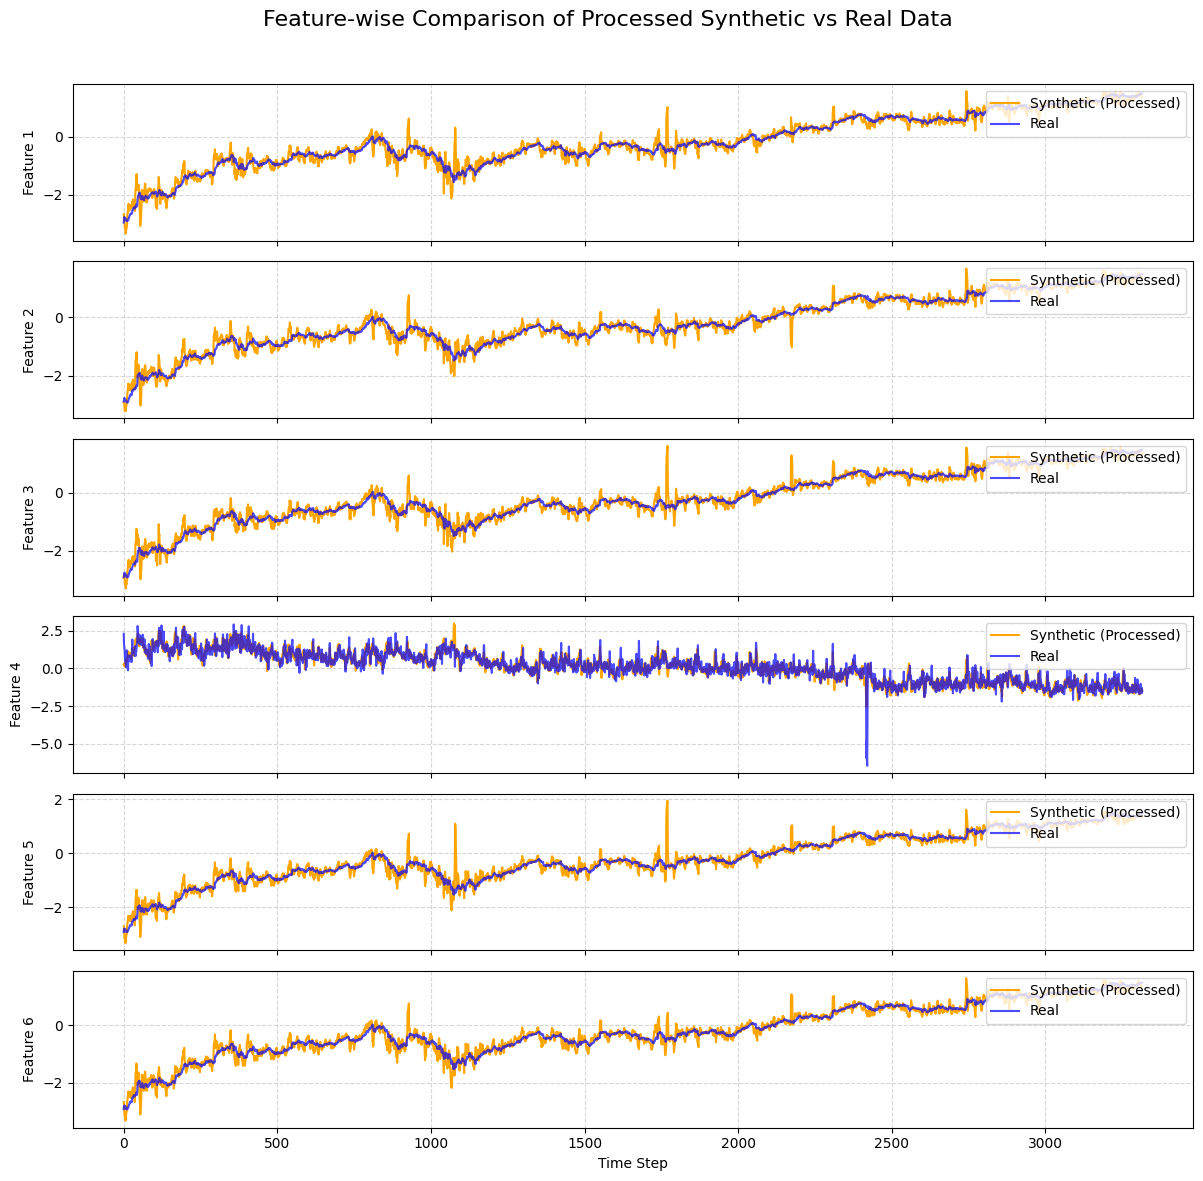

In [ ]:
# ==== Switches ====
APPLY_SMOOTHING = True       # Rolling mean
APPLY_RESCALE = True         # Match real variance/mean
APPLY_CLIP = False           # Clip in normalized space

# ==== Parameters ====
SMOOTH_WINDOW = 5          # Rolling window size for smoothing
CLIP_BOUNDS = (-4, 4)    # Min/max after normalization

# ==== Load ====
syn_data = np.load("")
real_data = np.load("")[0][:syn_data.shape[0]]

n_features = syn_data.shape[1]
processed_syn = syn_data.copy()

# ==== 1. Smoothing ====
if APPLY_SMOOTHING:
    for i in range(n_features):
        processed_syn[:, i] = pd.Series(processed_syn[:, i]).rolling(
            window=SMOOTH_WINDOW, center=True, min_periods=1
        ).mean()

# ==== 2. Rescale variance & mean to match real data ====
if APPLY_RESCALE:
    for i in range(n_features):
        syn_mean = processed_syn[:, i].mean()
        syn_std = processed_syn[:, i].std()
        real_mean = real_data[:, i].mean()
        real_std = real_data[:, i].std()

        if syn_std > 0:
            processed_syn[:, i] = real_mean + (real_std / syn_std) * (processed_syn[:, i] - syn_mean)

# ==== 3. Clip in normalized space ====
if APPLY_CLIP:
    for i in range(n_features):
        mean_before = processed_syn[:, i].mean()
        std_before = processed_syn[:, i].std()

        if std_before > 0:
            normalized = (processed_syn[:, i] - mean_before) / std_before
            clipped = np.clip(normalized, CLIP_BOUNDS[0], CLIP_BOUNDS[1])
            processed_syn[:, i] = mean_before + clipped * std_before

# ==== Plot ====
fig, axes = plt.subplots(n_features, 1, figsize=(12, 2*n_features), sharex=True)

for i in range(n_features):
    axes[i].plot(processed_syn[:, i], label='Synthetic (Processed)', color='orange')
    axes[i].plot(real_data[:, i], label='Real', color='blue', alpha=0.7)
    axes[i].set_ylabel(f'Feature {i+1}')
    axes[i].legend(loc='upper right')
    axes[i].grid(True, linestyle='--', alpha=0.5)

axes[-1].set_xlabel('Time Step')
fig.suptitle('Feature-wise Comparison of Processed Synthetic vs Real Data', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [ ]:
# ==============================================================================
# 0. Define Variables
# ==============================================================================
window_size = 24  # This should match the window size used for training the model

# ==============================================================================
# 1. Read and Load Both Files
# ==============================================================================
print("Step 1: Loading data...")
try:
    real_ts = real_data
    synthetic_ts = processed_syn
except FileNotFoundError as e:
    print(f"Error: {e}.")
    exit()

print(f"  - Loaded real data with shape: {real_ts.shape}")
print(f"  - Loaded synthetic data with shape: {synthetic_ts.shape}")
assert real_ts.shape == synthetic_ts.shape, "Real and synthetic time series must have the same shape."

# ==============================================================================
# 2. Create Sliding Windows
# ==============================================================================
print("\nStep 2: Creating sliding windows...")

def create_sliding_windows(data, window_size):
    """
    Creates a dataset of overlapping sliding windows from a single time series.

    Args:
        data (np.ndarray): The input time series of shape (total_length, num_features).
        window_size (int): The length of each window.

    Returns:
        np.ndarray: A new dataset of shape (num_windows, window_size, num_features).
    """
    total_length = data.shape[0]
    num_features = data.shape[1]

    num_windows = total_length - window_size + 1

    # Pre-allocate memory for efficiency
    windows = np.zeros((num_windows, window_size, num_features))

    for i in range(num_windows):
        windows[i] = data[i : i + window_size]

    return windows

real_windows = create_sliding_windows(real_ts, window_size)
synthetic_windows = create_sliding_windows(synthetic_ts, window_size)

print(f"  - Created {real_windows.shape[0]} real windows of shape {real_windows.shape[1:]}")
print(f"  - Created {synthetic_windows.shape[0]} synthetic windows of shape {synthetic_windows.shape[1:]}")

context_fid = Context_FID(real_windows, synthetic_windows)

print(f"Context FID: {context_fid}")

Step 1: Loading data...
  - Loaded real data with shape: (3316, 6)
  - Loaded synthetic data with shape: (3316, 6)

Step 2: Creating sliding windows...
  - Created 3293 real windows of shape (24, 6)
  - Created 3293 synthetic windows of shape (24, 6)


Encoding: 100%|██████████| 412/412 [00:01<00:00, 374.46it/s]


Context FID: 0.102
